In [10]:
import os

import numpy as np

from matplotlib import pyplot as plt

import pickle

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms


from datasets import BadNetsDataset, WaNetDataset
from simclr import SimClrBackbone

In [11]:
device = "cuda"
batch_size = 128

## Poison dataset

In [12]:
dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=False)
poison_dataset = BadNetsDataset(dataset, 0, "triggers/trigger_white.png", seed=1, transform=transforms.ToTensor())
#poison_dataset = WaNetDataset(dataset, 0, seed=1)
dataloader = DataLoader(poison_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Load SimCLR model

In [13]:
model = SimClrBackbone()

checkpoint_name = "WaNet-SimCLR_230.pt"

out = os.path.join('./saved_models/', checkpoint_name)
checkpoint = torch.load(out, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SimClrBackbone(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): C

## Extract features for all images

In [14]:
features = None
labels_poison = None
labels_true = None

for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

    with torch.no_grad():
        features_batch = model(img.to(device)).cpu().data.numpy()
        
    if features is None:
        features = features_batch
        labels_poison = labels_batch_poison
        labels_true = labels_batch_true
    else:
        features = np.append(features, features_batch, axis=0)
        labels_poison = np.append(labels_poison, labels_batch_poison, axis=0)
        labels_true = np.append(labels_true, labels_batch_true, axis=0)

labels = labels_true
labels[labels_true != labels_poison] = 10

num_classes = max(labels_poison) + 1

## Plot t-SNE features

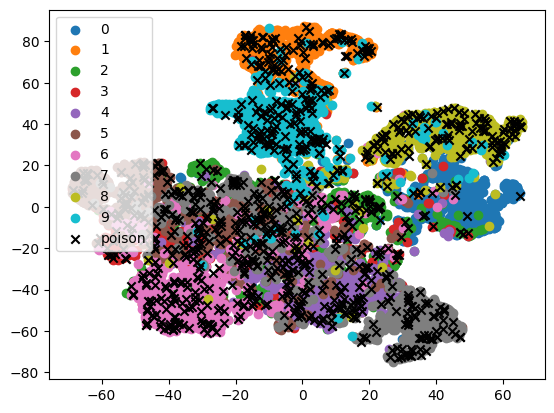

In [15]:
from sklearn.manifold import TSNE

# Plot only a subset
subset_size = 10000
features_subset = features[:subset_size]
labels_subset = labels[:subset_size]
    
tsne = TSNE(n_components = 2, perplexity = 50)
tsne_features = tsne.fit_transform(features_subset)

for i in range(num_classes):
    plt.scatter(tsne_features[labels_subset==i,1], tsne_features[labels_subset==i,0])
plt.scatter(tsne_features[labels_subset==10,1], tsne_features[labels_subset==10,0], c = "black", marker= "x")

plt.legend([str(i) for i in range(num_classes)] + ["poison"])
plt.show()

## kNN clean

In [16]:
from sklearn.neighbors import KNeighborsClassifier

examples_per_class = len(dataset) / num_classes

knn = KNeighborsClassifier(n_neighbors=int(examples_per_class/2))
knn.fit(features, labels)

KNeighborsClassifier(n_neighbors=500)

In [17]:
from IPython.display import clear_output

tp = 0
fp = 0
tn = 0
fn = 0

predicted_labels = []

for i in range(len(dataset)):
    feature = features[i]
    poison_label = labels_poison[i]
    true_label = labels_true[i]
    predicted_label = knn.predict(np.expand_dims(feature,0))

    predicted_labels.append(predicted_label)

    true_poison = poison_label != true_label
    predicted_poison = poison_label != predicted_label

    if true_poison and predicted_poison:
        tp += 1
    elif not true_poison and predicted_poison:
        fp += 1
    elif true_poison and not predicted_poison:
        fn += 1
    else:
        tn += 1

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"{i} / {len(dataset)}")
        print(f"\t {tp} \t {fp}")
        print(f"\t {fn} \t {tn}")

        fnr = fn/(fn+tp) if fn+tp!=0 else 0
        tnr = tn/(tn+fp) if tn+fp!=0 else 0
        poison_rate = fn/(fn+tn) if fn+tn!=0 else 0
        print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}")
        print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}")
        print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}")


clear_output(wait=True)
print(f"{len(dataset)} / {len(dataset)}")
print(f"\t {tp} \t {fp}")
print(f"\t {fn} \t {tn}")

fnr = fn/(fn+tp) if fn+tp!=0 else 0
tnr = tn/(tn+fp) if tn+fp!=0 else 0
poison_rate = fn/(fn+tn) if fn+tn!=0 else 0
print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

10000 / 10000
	 971 	 1947
	 29 	 7053
Percentage of poisoned images (out of all poisoned) kept:  2.90%
Percentage of clean images (out of all clean) kept:  78.37%
Percentage of remaining poisoned images (out of all remaining):  0.41%


CIFAR-10 train \
BadNets \
SimCLR_300

	50000 / 50000
		4943 	 9206
		57 	 35794
	Percentage of poisoned images (out of all poisoned) kept:  1.14%
	Percentage of clean images (out of all clean) kept:  79.54%
    Percentage of remaining poisoned images (out of all): 0.15%

CIFAR-10 test \
BadNets \
SimCLR_300

    10000 / 10000
        971     1947
        29 	    7053
	Percentage of poisoned images (out of all poisoned) kept:  2.90%
	Percentage of clean images (out of all clean) kept:  78.37%
    Percentage of remaining poisoned images (out of all): 0.41%

CIFAR-10 train \
WaNet \
SimCLR_230

    50000 / 50000
        4892 	 10176
        108 	 34824
    Percentage of poisoned images (out of all poisoned) kept:  2.16%
    Percentage of clean images (out of all clean) kept:  77.39%
    Percentage of remaining poisoned images (out of all):  0.31%

CIFAR-10 test \
WaNet \
SimCLR_230

    10000 / 10000
        952     2148
        48 	    6852
    Percentage of poisoned images (out of all poisoned) kept:  4.80%
    Percentage of clean images (out of all clean) kept:  76.13%
    Percentage of remaining poisoned images (out of all): 0.69%

In [18]:
save_name = "SimCLR_cleanse"

with open(f"./cleansed_labels/{save_name}.pkl", "wb") as f:
    pickle.dump(predicted_labels, f)